<a href="https://colab.research.google.com/github/aidancrilly/MiniCourse-DifferentiableSimulation/blob/main/Extended00_JAXIntro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extened introduction to JAX:

Extended for I-X Programming Club 2th Dec 2025

Resources:

- JAX documentation: https://docs.jax.dev/en/latest/quickstart.html


# What is JAX?

"JAX is a Python library for accelerator-oriented array computation and program transformation, designed for high-performance numerical computing and large-scale machine learning. It is developed by Google"

JAX uses the Open XLA compiler to compile the same code to run on CPU, GPU and TPU

Below are the key libraries to import to use JAX, if you are familiar with regular numpy then jax.numpy will be easy to pick

In [1]:
!pip install optax equinox
import jax
import jax.numpy as jnp

In this introduction, we will go through the key capabilities of JAX, namely:

- Just-in-time (JIT) compilation
- Vectorising maps
- Automatic differeniation

These are implemented as JAX's key 'transformations':

- jax.jit
- jax.vmap
- jax.grad

These transformations take a function as an argument and return a transformed version of the function. 

You can use the transformations as functions or decorators. For example:

```python3

def cos_sin(x):
    return jnp.cos(jnp.sin(x))

jitted_cos_sin = jax.jit(cos_sin)

```

or

```python3
@jax.jit
def jitted_cos_sin(x):
    return jnp.cos(jnp.sin(x))
```


The magic behind transformations is the notion of a JAX Tracer. Tracers are abstract stand-ins for array objects, and are passed to JAX functions in order to extract the sequence of operations that the function encodes. The need for these tracers to be abstract also restricts the kind of functions we can write as we shall see in the following.

We won't aim to understand what exactly is happening at the low level but more review the functionality and how to use it for our use case.

# Just-in-time (JIT) compilation

As the name suggests, JIT compiles a function at run time, just in time for its execution. As mentioned above, JAX uses the Open XLA compiler ecosystem which natively supports accelerators.

Lets try out jax.jit in a simple example.

In [2]:
def cosine_similatiries(x, y):
  """
  Computes the cosine similarity between two vectors.

  We will use very large input vectors for x and y
  """
  x_norm = jnp.sum(x ** 2) ** 0.5
  y_norm = jnp.sum(y ** 2) ** 0.5
  return jnp.sum(x * y) / (x_norm * y_norm)

def pythonic_cosine_similatiries(x, y):
  """
  For comparison
  """
  x = list(x)
  y = list(y)
  x_norm = 0.0
  y_norm = 0.0
  for i in range(len(x)):
    x_norm += x[i] ** 2
    y_norm += y[i] ** 2
  x_norm = x_norm ** 0.5
  y_norm = y_norm ** 0.5
  return sum(x[i] * y[i] for i in range(len(x))) / (x_norm * y_norm)



To JIT compile code we simple call jax.jit on the function which returns the jitted function.

**Note**: compiliation occurs whenever the shape of the inputs change or whenever a variable specified as static is changed in value.

In [3]:
jitted_cosine_similatiries = jax.jit(cosine_similatiries)

To test our functions, lets make some random numbers, we explicitly deal with the random number generator keys - a JAX quirk that you quickly get used to.

In [4]:
N = 10000

seed = 1337
key = jax.random.key(seed)

key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (N,))
key, subkey = jax.random.split(key)
y = jax.random.normal(subkey, (N,))

We can compare the run times of our various implementations, python, JAX with and without JIT (as well as see how long the code takes to compile).

In [5]:
import timeit

python_time = timeit.timeit(lambda: pythonic_cosine_similatiries(x, y), number=1)
jax_time = timeit.timeit(lambda: cosine_similatiries(x, y), number=100)/100
compile_time = timeit.timeit(lambda: jitted_cosine_similatiries(x, y), number=1)
jit_time = timeit.timeit(lambda: jitted_cosine_similatiries(x, y), number=100)/100

print(f'Python time: {1e3*python_time:.4f} ms')
print(f'JAXPython time: {1e3*jax_time:.4f} ms')
print(f'Compile time: {1e3*compile_time:.4f} ms')
print(f'JIT time: {1e3*jit_time:.4f} ms')

Python time: 2024.9357 ms
JAXPython time: 1.0641 ms
Compile time: 76.5295 ms
JIT time: 0.0226 ms


JIT seems pretty amazing - it also can compile code for accelerators like GPU and CPU

**However**, there are things you can't jit, including:

- Functions with 'side effects' or impure functions, basically you need to pass all arguments to the function rather than relying on state
- Functions which include dynamically shaped arrays, if any array in the function would change shape based on the inputs this makes the function not traceable
- Functions which include python control flow (if/then/else), again this makes the function not traceable as you can't work out which branch of the if/then/else you should take at compile time.


In [6]:
def variable_length_result(x,n):
  res = jnp.linspace(0.0,x,n)
  return res

x = 0.25
n = 5

nojit_res = variable_length_result(x,n)
print(nojit_res)

[0.     0.0625 0.125  0.1875 0.25  ]


In [7]:
jitted_res = jax.jit(variable_length_result)(x,n)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[]
'num' argument of jnp.linspace
The error occurred while tracing the function variable_length_result at C:\Users\Aidan Crilly\AppData\Local\Temp\ipykernel_30724\2770435341.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument n.

See https://docs.jax.dev/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [ ]:
# static_argnames tells JAX to recompile on changes at these argument positions:
jitted_res = jax.jit(variable_length_result, static_argnames=['n'])(x,n)
print(jitted_res)

[0.     0.0625 0.125  0.1875 0.25  ]


The above also applies for python-like if statements, in general these should be avoid and conditionals should be done with in-built JAX conditionals such as jnp.where.

Below is some example code that shows this issue and the solution

In [ ]:
def jax_w_nojittable_conditional(x, threshold):
    if x > threshold:
        return x
    else:
        return 0.0
    
# This will fail because the conditional depends on a JAX array value at tracing time
failing_jit = jax.jit(jax_w_nojittable_conditional)
try:
    y = failing_jit(0.75, 0.5)
    print(y)
except Exception as e:
    print(f'JIT failed with error: {e}')

# This will work because we use jnp.where which is JIT-compatible (and vectorised)
x = jnp.linspace(0.0,1.0,100)
y = jnp.where(x > 0.5, x, 0)
print(y)

JIT failed with error: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function jax_w_nojittable_conditional at C:\Users\Aidan Crilly\AppData\Local\Temp\ipykernel_15572\2262451346.py:1 for jit. This concrete value was not available in Python because it depends on the values of the arguments x and threshold.
See https://docs.jax.dev/en/latest/errors.html#jax.errors.TracerBoolConversionError
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.5050505  0.5151515  0.5252525  0.53535354
 0.54545456 0.5

# Vectorising map (jax.vmap)

Another key JAX functionality is the *vmap*, which allows you vectorise a function over (all or a subset) of its inputs. Basically, if you are performing the same operation along an axis of an array, vmap is made to handle this.

This happens a lot with batches in an ML context but also fully parallel operations in scientific computing. A simple example here is batched dot-products

In [9]:
def dot_products(a, b):
    return jnp.dot(a, b)

# Now we can vmap this function over the first axis of a and b
batched_dot_products = jax.vmap(dot_products, in_axes=(0,0))
# Create some batched data
key, subkey = jax.random.split(key)
a = jax.random.normal(subkey, (100, 50))
key, subkey = jax.random.split(key)
b = jax.random.normal(subkey, (100, 50))
# Compute batched dot products
result = batched_dot_products(a, b)
print(result.shape) #(100,) - one dot product per batch item

(100,)


For a more complex example, lets only vmap over some axes, but not others.

Let us compute the mean and variance over the first axis of a 2D data array *x*, including a weighting term *w* which is the same for all rows of *x*.

In [ ]:
def compute_cumulants(x,w):
  mu = jnp.sum(w*x)/jnp.sum(w)
  var = jnp.sum(w*(x-mu)**2)/jnp.sum(w)
  return mu, var

# in_axes specifies over which axis the vectorising map should occur
# None here says no vectorisation should be used, i.e. use the same w for all x
vmapped_compute_cumulants = jax.vmap(compute_cumulants,in_axes=(1,None))

Nx1 = 100
Nx2 = 20

key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (Nx1,Nx2))
key, subkey = jax.random.split(key)
w = jax.random.normal(subkey, (Nx1))**2

mu, var = vmapped_compute_cumulants(x,w)
print(mu.shape)
print(var.shape)

(20,)
(20,)


# JAX quirks

JAX's capabilities make for a few quirks when compared to native python/numpy code.

## Random numbers

We have already seen this in the random number generation above, JAX makes you keep explicit track of your Pseudo Random Number Generator (PRNG or just RNG) key. You can split the key to form more keys sharings the same root, such that it is deterministic 

In [11]:
key = jax.random.key(seed=42)

# Split the key to get new keys
key1, key2 = jax.random.split(key)
print(f'Original key: {key}, key1: {key1}, key2: {key2}')

# We can use these keys to generate random numbers
rand1 = jax.random.normal(key1, (5,))
rand2 = jax.random.normal(key2, (5,))
print(f'Random numbers from key1: {rand1}')
print(f'Random numbers from key2: {rand2}')


Original key: Array((), dtype=key<fry>) overlaying:
[ 0 42], key1: Array((), dtype=key<fry>) overlaying:
[1832780943  270669613], key2: Array((), dtype=key<fry>) overlaying:
[  64467757 2916123636]
Random numbers from key1: [ 0.07592554 -0.48634264  1.2903206   0.5196119   0.30040437]
Random numbers from key2: [ 0.60576403  0.7990441  -0.908927   -0.63525754 -1.2226585 ]


## In-place updates

We must interact with JAX arrays in a different way than in python/numpy.

In [ ]:
x = jnp.array([1.0,2.0,3.0,4.0])

# This is not allowed
try:
  x[1] = -2.0
except TypeError as e:
  print('Numpy-like array updates not allowed:')
  print(e)

# You have to use the following syntax to perform in-place update
x = x.at[1].set(-2.0)
print('\nUsing in-place updates:')
print(x)

Numpy-like array updates not allowed:
JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://docs.jax.dev/en/latest/_autosummary/jax.numpy.ndarray.at.html

Using in-place updates:
[ 1. -2.  3.  4.]


## PyTrees

"A pytree is a container-like structure built out of container-like Python objects — “leaf” pytrees and/or more pytrees. A pytree can include lists, tuples, and dicts. A leaf is anything that’s not a pytree, such as an array, but a single leaf is also a pytree.

In the context of machine learning, a pytree can contain:

 - Model parameters
 - Dataset entries
 - Reinforcement learning agent observations

When working with datasets, you can often come across pytrees (such as lists of lists of dicts)."

JAX transformations work with Pytrees, as well as additional functionality from jax.tree.

Easiest example is a dictionary, taking our mean and variance vmap example from before:

In [ ]:
def pytree_compute_cumulants(inputs):
  mu = jnp.sum(inputs['w']*inputs['x'])/jnp.sum(inputs['w'])
  var = jnp.sum(inputs['w']*(inputs['x']-mu)**2)/jnp.sum(inputs['w'])
  return dict(mu=mu, var=var)

# in_axes specifies over which axis the vectorising map should occur
# None here says no vectorisation should be used, i.e. use the same w for all x
vmapped_pytree_compute_cumulants = jax.vmap(pytree_compute_cumulants,in_axes=({'x':1,'w':None},))

Nx1 = 100
Nx2 = 20

key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (Nx1,Nx2))
key, subkey = jax.random.split(key)
w = jax.random.normal(subkey, (Nx1))**2

outputs = vmapped_pytree_compute_cumulants(dict(x=x,w=w))
print(outputs)

{'mu': Array([-0.12768067,  0.17664544, -0.12315524,  0.32680625, -0.29204148,
       -0.30912367,  0.02609504,  0.17999336, -0.0183472 , -0.11280745,
        0.14744054,  0.1177633 ,  0.07179267, -0.12878808, -0.11468341,
       -0.09555981, -0.11572444,  0.3645342 , -0.05549572,  0.5657783 ],      dtype=float32), 'var': Array([1.5941023 , 0.8457816 , 1.2125467 , 1.1196818 , 0.60482544,
       0.8819172 , 0.6382584 , 1.311954  , 0.8868242 , 0.7390996 ,
       1.0321418 , 0.7179358 , 1.1348128 , 0.7884317 , 0.78116   ,
       0.9332015 , 0.74374044, 0.96079934, 1.1674564 , 1.2903014 ],      dtype=float32)}


# Automatic Differentiation

## jax.grad

jax.grad is the simpliest interface with JAX's automatic differentation (AD) capability. It works exclusively on scalar output functions (input can be multi-dimensional) - and it implements *reverse-mode* AD as this is most efficient for many-to-one functions.

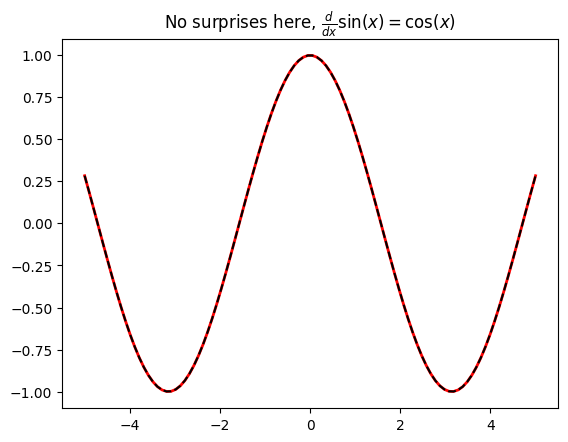

In [ ]:
import matplotlib.pyplot as plt

def sin_func(x):
  return jnp.sin(x)

x = jnp.linspace(-5,5,100)

# Note we need to vmap our gradded function as jax.grad operates on scalar output functions only
grad_sin_func = jax.vmap(jax.grad(sin_func))
y = grad_sin_func(x)

plt.title(r'No surprises here, $\frac{d}{dx} \sin (x) = \cos (x)$')
plt.plot(x,y,'r',lw=2)
plt.plot(x,jnp.cos(x),'k--')
plt.show()

Or with Pytrees

See the following example:

In [ ]:
def sin_variable_w_func(input):
  return jnp.sin(input['w']*input['x'])

# First for scalars
input = {'w' : 2.0, 'x' : 1.0}

scalar_grad_sin_variable_w_func = jax.grad(sin_variable_w_func)
scalar_grad_sin_variable_w_func(input)

{'w': Array(-0.41614684, dtype=float32, weak_type=True),
 'x': Array(-0.8322937, dtype=float32, weak_type=True)}

We can compose transformations, here a vmap on a grad

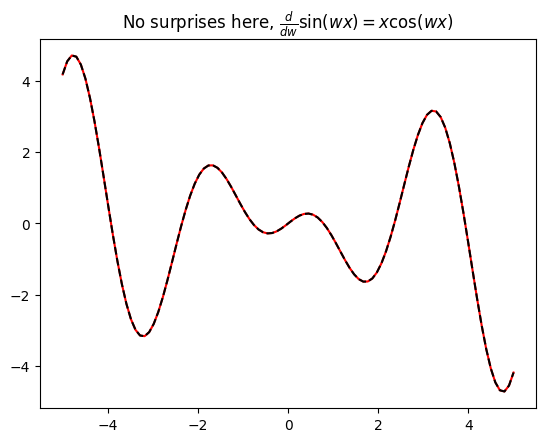

In [ ]:
# Now for scalar w and vector x

input = {'w' : 2.0, 'x' : jnp.linspace(-5,5,100)}

vector_x_grad_sin_variable_w_func = jax.vmap(scalar_grad_sin_variable_w_func,
                                             in_axes=({'w' : None, 'x' : 0},))
out = vector_x_grad_sin_variable_w_func(input)

plt.title(r'No surprises here, $\frac{d}{dw} \sin (w x) = x \cos (w x)$')
plt.plot(x,out['w'],'r')
plt.plot(x,input['x']*jnp.cos(input['w']*input['x']),'k--')
plt.show()

## jax.jacfwd and jax.jacrev

We can also compute the gradients of functions with multi-dimensional outputs, in particular we can compute the Jacobian of function $f(x)$ where $x$ is n-dimensional and $f(x)$ returns an m-dimensional vector.

Mathematically, $J_f(x)$ is the Jacobian:

$$
  J_f(x) = \begin{bmatrix} \frac{d f_1}{dx_1} & \dots & \frac{d f_1}{dx_n} \\
  \vdots & & \vdots \\
  \frac{d f_m}{dx_1} & \dots & \frac{d f_m}{dx_n} \end{bmatrix}
$$

We can compute the Jacobian in forward- or reverse-mode automatic differentiation (jacfwd and jacrev respectively).

In [ ]:
def sin_cos_func(x):
  """
  Test function with two outputs
  """
  return jnp.array([jnp.sum(jnp.sin(x)), jnp.sum(jnp.cos(x))])

x = jnp.linspace(-5,5,100)

forwardmode_jac = jax.jacfwd(sin_cos_func)
reversemode_jac = jax.jacrev(sin_cos_func)

forwardmode_out = forwardmode_jac(x)
reversemode_out = reversemode_jac(x)

print(f'The shape of the forward-mode Jacobian is {forwardmode_out.shape}')
print(f'The shape of the reverse-mode Jacobian is {reversemode_out.shape}')

assert jnp.isclose(forwardmode_out,reversemode_out).all()
# Note forwardmode_out =/= reversemode_out ! they involve different FLOPs

The shape of the forward-mode Jacobian is (2, 100)
The shape of the reverse-mode Jacobian is (2, 100)


We noted in the lecture that reverse-mode is more efficient for many-to-few functions, lets test this with our many-to-few test function

In [ ]:
forwardmode_jac = jax.jit(forwardmode_jac)
reversemode_jac = jax.jit(reversemode_jac)

x_big = jnp.linspace(-5,5,1000)

forwardmode_time = timeit.timeit(lambda: forwardmode_jac(x_big), number=100)/100
reversemode_time = timeit.timeit(lambda: reversemode_jac(x_big), number=100)/100

print(f'Forward-mode time: {1e3*forwardmode_time:.4f} ms')
print(f'Reverse-mode time: {1e3*reversemode_time:.4f} ms')

Forward-mode time: 6.5023 ms
Reverse-mode time: 2.4820 ms


# Classes and JAX

Python classes and JAX are more difficult to mesh together as the 'state' of classes can mess with the tracing of a class method - see below for example from JAX docs.

We implement a simple counter class which has an attribute n which is incremented. This counts as a side-effect so is not compatible with jit.

In [ ]:
class Counter:
  """A simple counter."""

  def __init__(self):
    self.n = 0

  def count(self) -> int:
    """Increments the counter and returns the new value."""
    self.n += 1
    return self.n

  def reset(self):
    """Resets the counter to zero."""
    self.n = 0


counter = Counter()
fast_counter = jax.jit(counter.count)

for _ in range(3):
  print(f'fast_counter returns: {fast_counter()}')
  print(f'counter.count() returns: {counter.count()}')

fast_counter returns: 1
counter.count() returns: 2
fast_counter returns: 1
counter.count() returns: 3
fast_counter returns: 1
counter.count() returns: 4


Equinox is JAX library which allows for class-like objects in JAX, this is useful for implementing neural networks. The parameters of the model can be attributes of an equinox module

In [ ]:
import equinox as eqx

class LinearLayer(eqx.Module):
    # Define the parameters of the layer
    # This looks similar to a PyTorch nn.Module or python dataclass
    w: jnp.ndarray
    b: jnp.ndarray

    def __init__(self, in_features: int, out_features: int, key: jnp.ndarray):
        w_key, b_key = jax.random.split(key)
        self.w = jax.random.normal(w_key, (out_features, in_features))
        self.b = jax.random.normal(b_key, (out_features,))

    def __call__(self,x) -> jnp.ndarray:
        return jnp.dot(self.w, x) + self.b
    
key, subkey = jax.random.split(key)
layer = LinearLayer(in_features=3, out_features=2, key=subkey)
x = jnp.array([1.0, 2.0, 3.0])
y = layer(x)
print(y)
print(f'Layer parameters: w shape {layer.w.shape}, b shape {layer.b.shape}')   


[0.4723825 3.0692925]
Layer parameters: w shape (2, 3), b shape (2,)


# Optimisation in JAX - optax

Another useful JAX library is optax. It implements key optimisers in JAX - allowing the training of ML models (or any gradient-based optimisation problem).

Here is an example we will see again in exercise 2, a simple convex optimisation problem using gradient descent

Text(0, 0.5, 'Loss')

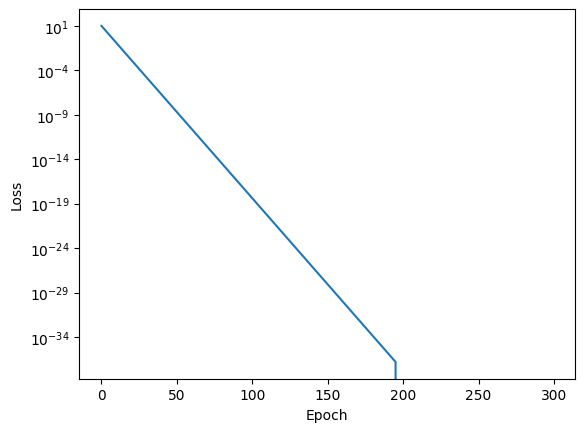

In [ ]:
import optax

def example_loss(p):
  return jnp.sum(p**2)

# Initialize parameters of the "model" + optimizer.
learning_rate = 1e-1
optimizer = optax.sgd(learning_rate)

p0 = jnp.ones((10,))
opt_state = optimizer.init(p0)

# A simple update loop
Nepoch = 300
grad_loss = jax.value_and_grad(example_loss)
p = p0.copy()
history = []
for _ in range(Nepoch):
  loss,grads = grad_loss(p)
  # Optax optimizer uses the gradients to update the parameters and the optimiser state
  updates, opt_state = optimizer.update(grads, opt_state)
  p = optax.apply_updates(p, updates)
  history.append(loss)

import matplotlib.pyplot as plt
plt.semilogy(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')

## Continuing AD

### **Advanced**: Jacobian-vector products (JVPs) and vector-Jacobian products (VJPs)

To really understand what is happening under the hood, we need to introduce JVPs and VJPs, which are related to forward- and reverse-mode AD respectively.

Let’s say you have a function that takes several inputs and returns several outputs. Think of this like a physical system where you tweak some parameters (the inputs) and observe some measurements (the outputs). The Jacobian of this function is like a giant matrix of sensitivities—how each output changes with each input.

But in practice, we don’t usually need the whole matrix when applying the chain rule.

Instead, we want to know what happens in a particular direction. That’s where Jacobian-vector products (JVPs) and vector-Jacobian products (VJPs) come in.

**Jacobian-Vector Product (JVP)**

This is used in forward-mode AD. It answers the question:

*“If I nudge my inputs a little bit in some direction, how do the outputs change?”*

Imagine you’re computing a function, $f(x)$, and you have some small perturbation $\delta x$. The JVP tells you how that perturbation propagates through the function:

$$
JVP =  J_f(x) \cdot \delta x
$$

You can think of the JVP like sending a small ripple through your system from the input side and seeing how it affects the output.

The JVP is efficient when the function, $f(x)$, is few-to-many (small number of inputs, large number of outputs).


In [ ]:
def test_function(x):
  res = {
      'f0' : (jnp.sin(x[1])+x[2]*jnp.sin(x[3]))*jnp.exp(x[0]),
      'f1' : (jnp.sin(x[1])+x[2]*jnp.sin(x[3]))*jnp.exp(-x[0])
  }
  return res

x = jnp.array([1.0,2.0,3.0,4.0])

# To get df/dx[i] for each i, we need to sweep through the JVP on the input space
for i in range(len(x)):
  v = jnp.eye(len(x))[i]
  y, u = jax.jvp(test_function, (x,), (v,))
  print(f'df/dx[{i}] = {u}')

**Vector-Jacobian Product (VJP)**

This is used in reverse-mode AD. It answers the question:

*“How does a particular change in the outputs trace back to affect the inputs?”*

$$
VJP = \delta y^T \cdot J_f(x)
$$

This is like backpropagating a signal from the output side—asking how a change in a measurement pushes back through the system to influence the inputs. This is the basis for how gradients are computed efficiently when you have lots of inputs but only one output.

In [ ]:
y, vjp_fun = jax.vjp(test_function, x)

# To get df[j]/dx for each j, we need to sweep through the VJP on the output space
v = {'f0' : 1.0, 'f1' : 0.0}
u = vjp_fun(v)
print(f'df[0]/dx = {u}')

v = {'f0' : 0.0, 'f1' : 1.0}
u = vjp_fun(v)
print(f'df[1]/dx = {u}')

Note we get the same answer as with the JVP but with two calls to the VJP vs four calls to the VJP.

As a sanity check, here we compute the Jacobian using jacfwd and jacrev

In [ ]:
print(jax.jacfwd(test_function)(x))
print(jax.jacrev(test_function)(x))